# Fast Break
Can we tell when a fast break is happening? (increases XG)

In [70]:
# Add this so we can import our haxml code from outside the notebooks folder.
import sys
sys.path.append("../")

from haxml.prediction import (
    generate_rows_demo
)
from haxml.utils import (
    load_match,
    inflate_match,
    get_stadiums,
    get_matches_metadata,
    to_clock,
    train_test_split_matches_even_count
)
from haxml.viz import (
    plot_stadium,
    zoom_stadium,
    plot_positions
)
from matplotlib.figure import Figure
import matplotlib.pyplot as plt
import json
import pandas as pd
from tqdm import tqdm

In [2]:
stadiums = get_stadiums("../data/stadiums.json")
metadata = get_matches_metadata("../data/matches_metadata.csv")

In [135]:
meta = metadata[344]
meta

{'match_id': '-MPTFOrzRZxpAlePLlM7',
 'stadium': 'NAFL Official Map v1',
 'time': 255.5,
 'kicks_red': 84,
 'kicks_blue': 56,
 'score_red': 1,
 'score_blue': 2,
 'scored_goals_red': 1,
 'scored_goals_blue': 1}

In [136]:
key = meta["match_id"]
infile = "../data/packed_matches/{}.json".format(key)
stadium = stadiums[meta["stadium"]]
match = load_match(infile)
row_gen = generate_rows_demo(match, stadium)
df = pd.DataFrame(row_gen)
df["match"] = key

In [137]:
df.query("ag == 1").head()

,ag,index,time,x,y,goal_x,goal_y,goal_distance,goal_angle,team,stadium,match
12,1,12,24.4,-157.0,-263.0,-700,0,603.339042,1.119750,blue,NAFL Official Map v1,-MPTFOrzRZxpAlePLlM7
21,1,21,39.2,574.0,107.0,700,0,165.302753,0.866763,red,NAFL Official Map v1,-MPTFOrzRZxpAlePLlM7


In [138]:
pd.DataFrame(match["positions"]).head(10)

,type,time,x,y,playerId,name,team
0,player,0.0,200.0,0.0,89.0,Player 235,blue
1,player,0.0,200.0,55.0,90.0,Player 236,blue
2,player,0.0,200.0,-55.0,55.0,Player 132,blue
3,player,0.0,200.0,110.0,39.0,Player 212,blue
4,player,0.0,-200.0,0.0,91.0,Player 237,red
5,player,0.0,-200.0,55.0,76.0,Player 35,red
6,player,0.0,-200.0,-55.0,83.0,Player 233,red
7,player,0.0,-200.0,110.0,42.0,Player 221,red
8,ball,0.0,0.0,0.0,NaN,None,None
9,player,0.3,100.0,-34.0,89.0,Player 235,blue


## Let's try to get the speed of the ball

In [139]:
df1 = pd.DataFrame(match["kicks"])
df1.loc[df1['type'] == "steal"]

# after a ball is stolen and it goes in the final 3rd

# steal the ball in the second opponents half
# find out how long the ball was in possesion

,time,type,fromId,fromX,fromY,fromName,fromTeam,toId,toX,toY,toName,toTeam
1,4.4,steal,83,181.0,-277.0,Player 233,red,90.0,292.0,285.0,Player 236,blue
2,6.3,steal,90,291.0,291.0,Player 236,blue,42.0,-157.0,234.0,Player 221,red
3,8.3,steal,42,-140.0,180.0,Player 221,red,89.0,105.0,-30.0,Player 235,blue
4,10.1,steal,89,105.0,-30.0,Player 235,blue,83.0,-68.0,-240.0,Player 233,red
7,16.7,steal,90,178.0,121.0,Player 236,blue,83.0,138.0,151.0,Player 233,red
...,...,...,...,...,...,...,...,...,...,...,...,...
127,235.9,steal,89,621.0,-268.0,Player 235,blue,83.0,640.0,-300.0,Player 233,red
130,241.3,steal,55,167.0,-267.0,Player 132,blue,42.0,-242.0,-150.0,Player 221,red
131,242.2,steal,42,-241.0,-152.0,Player 221,red,89.0,60.0,-102.0,Player 235,blue
135,250.8,steal,91,-665.0,217.0,Player 237,red,55.0,-614.0,257.0,Player 132,blue


In [140]:
def get_positions_in_range(positions, start, end):
    """
    Return a list of positions (dicts) between start and end (inclusive).
    """
    assert start <= end, "Time `start` must be before `end`."
    
    def is_in_time_range(pos):
        return pos["time"] >= start and pos["time"] <= end
    
    return list(filter(is_in_time_range, positions))

In [141]:
sample = pd.DataFrame(match["kicks"]).query("type == 'steal'").to_dict(orient="records")[1]
offset = 2
print("Get positions between {} and {}.".format(sample["time"], sample["time"] + offset))
r2 = get_positions_in_range(match["positions"],sample["time"], sample["time"] + offset)
pd.DataFrame(r2)

Get positions between 6.3 and 8.3.


,type,time,x,y,playerId,name,team
0,player,6.4,164.0,81.0,89.0,Player 235,blue
1,player,6.4,90.0,239.0,90.0,Player 236,blue
2,player,6.4,38.0,121.0,55.0,Player 132,blue
3,player,6.4,294.0,134.0,39.0,Player 212,blue
4,player,6.4,72.0,263.0,91.0,Player 237,red
...,...,...,...,...,...,...,...
67,player,8.2,126.0,158.0,91.0,Player 237,red
68,player,8.2,192.0,-71.0,76.0,Player 35,red
69,player,8.2,30.0,-152.0,83.0,Player 233,red
70,player,8.2,-90.0,124.0,42.0,Player 221,red


351.81387124444086
652.2162218160478
746.00268096033
{'time': 39.2, 'type': 'pass', 'fromId': 39, 'fromX': 755.0, 'fromY': -17.0, 'fromName': 'Player 212', 'fromTeam': 'blue', 'toId': 89.0, 'toX': 9.0, 'toY': -19.0, 'toName': 'Player 235', 'toTeam': 'blue'}


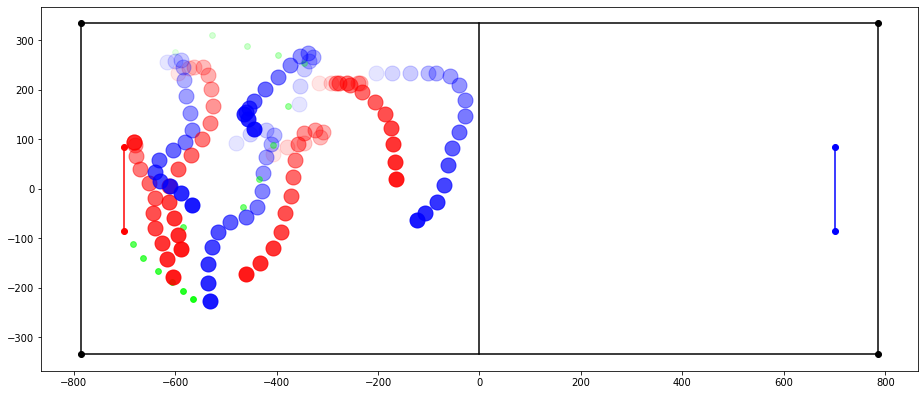

In [142]:
import math
offset = 2
show_trail = True
steals = pd.DataFrame(match["kicks"]).query("type == 'pass'").to_dict(orient="records")
dist = 0
stea = None
for steal in steals:
    dist_st = math.sqrt((steal['toX']-steal['fromX'])**2 + (steal['toY']-steal['fromY'])**2)
    if dist_st > dist:
        dist = dist_st
        stea = steal
        print(dist_st)
print(stea)
if show_trail:
    after_steal = get_positions_in_range(match["positions"], steal["time"]-offset, steal["time"]+offset)
fig, ax = plot_positions(after_steal, stadium)
w, h = zoom_stadium(stadium["bounds"])
fig.set_size_inches(w, h)
fig

In [100]:
def make_df(metadata, callback, progress=False):
    """
    Transforms match metadata into a DataFrame of records for
    each kick, including target label and features.
    Args:
        metadata: Match metadata (list of dicts).
        callback: Method to run on each match to extract kicks.
        progress: Whether or not to show progress bar (boolean).
    Returns:
        DataFrame where each row is a kick record.
    """
    rows = []
    bar = tqdm(metadata) if progress else metadata
    for meta in bar:
        key = meta["match_id"]
        infile = "../data/packed_matches/{}.json".format(key)
        try:
            s = stadiums[meta["stadium"]]
            row_gen = load_match(infile, lambda m: callback(m, s))
            for row in row_gen:
                row["match"] = key
                rows.append(row)
        except FileNotFoundError:
            pass
    return pd.DataFrame(rows)

In [71]:
train, test = train_test_split_matches_even_count(metadata)
d_train = make_df(train, generate_rows_demo, progress=True)
d_test = make_df(test, generate_rows_demo, progress=True)

100%|██████████| 393/393 [00:03<00:00, 122.43it/s]


In [118]:
clf = RandomForestClassifier(max_depth=2, random_state=0)

NameError: name 'RandomForestClassifier' is not defined

In [119]:
from haxml.utils import get_opposing_goalpost
# some math for the distance, I could do this but it seems too excessive
posts_blue = get_opposing_goalpost(stadium, "red")["posts"]
posts_blue

get_opposing_goalpost(stadium, "red")["posts"][1]['x']

bounds = stadium["bounds"]
bounds["maxX"] * 2 / 18

87.22222222222223